In [40]:
from pathlib import Path
import shutil
import os
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
cwd = os.getcwd()

In [41]:
# number of samples per class to select
N = 750

# train val split
SPLIT = 2/3

# size for cutting out of frames
CUT_SIZE = 400

# size of frames to be fed to the network
SIZE = 256

In [42]:
p = Path(cwd, 'raw_data')

### get frames of video

In [43]:
# p = p / 'vid001.mp4'
# os.system("ffmpeg -i "+str(p)+" -r 1/1 raw_data/frames/%05d.bmp")

### get data frame with monkey bb's

drop all monky-less frames

---

results file contents
- rows of: '{frame},{id},{x1},{y1},{w},{h},{score},{cls_id},1\n'
  - class ID's: monkey,patch,kong,branch,XBI
  - frame ID's are all +1

In [44]:
bb_df = pd.read_csv(str((p / 'results.txt')), sep=',', names=['frame','id','x1','y1','w','h','score','cls_id','1'])

# drop last column thats always 1 and score as we ingnore it either way
bb_df.drop(['1', 'score'], axis=1, inplace=True)

# drop all rows not containing a bb for a monkey
bb_df = bb_df[bb_df.cls_id == 0]

# drop column containing cls_id
bb_df.drop('cls_id', axis=1, inplace=True)

# substract 1 from frame column
bb_df.frame -= 1

# drop id column as we do not have a need for it
bb_df.drop('id', axis=1, inplace=True)

# set frame column as index column
bb_df.set_index('frame', inplace=True)

bb_df

,x1,y1,w,h
frame,,,,
0,420.844788,186.737427,224.581787,157.413940
1,421.616690,187.334521,223.154584,156.398481
2,421.174133,187.133186,223.494356,156.709724
3,421.281979,187.206122,223.030090,156.409062
4,421.140797,187.421083,221.930143,155.795984
...,...,...,...,...
20995,620.534945,307.258562,195.949614,179.308152
20996,619.245913,308.421343,192.397138,177.108591
20997,618.442531,308.309059,191.720266,177.593681


### get data frame with pose information

---

- drop rows containing interactions
- get set of distinct poses

In [45]:
label_df = pd.read_csv(str((p / 'hum_2021-09-21_M1-2_cam19415032_vid001.mp4.txt')), sep=' ', names=['frame','from','to','pose_or_action'])

# drop all rows containing interactions
label_df = label_df[label_df.to == '-']

# drop to column as it is no longer needed
label_df.drop('to', axis=1, inplace=True)

# rename last column as contents are now cleaned up
label_df.rename(columns={'pose_or_action': 'pose'}, inplace=True)

# can drop from column there is only one monkey either way...even if it is detected with multiple ID's
label_df.drop('from', axis=1, inplace=True)

# set frame column as index column
label_df.set_index('frame', inplace=True)

label_df

,pose
frame,
0,walking
1,walking
2,walking
3,walking
4,walking
...,...
20986,walking
20987,walking
20988,walking


In [46]:
labels = label_df.pose.unique()
labels

array(['walking', 'standing4legs', 'sitting', 'standing2legs'],
      dtype=object)

### create combined df

---

combine df's of monkey bb's and according pose label

join tables on frame number
- use merge instead of join (takes by default inner join and thus only matches intersection of keys)




In [47]:
joined_df = bb_df.merge(label_df, left_index=True, right_index=True)

# turn bb values to int
joined_df[['x1','y1','w','h']] = joined_df[['x1','y1','w','h']].astype(int)

joined_df

,x1,y1,w,h,pose
frame,,,,,
0,420,186,224,157,walking
1,421,187,223,156,walking
2,421,187,223,156,walking
3,421,187,223,156,walking
4,421,187,221,155,walking
...,...,...,...,...,...
20986,621,302,204,175,walking
20987,622,303,202,176,walking
20988,621,303,204,179,walking


### generate trainings data

---

- get similar numbers of different poses in train and validation sets
- *future* also get similar numbers accross different videos

In [48]:
# get sample count per label
for l in labels:
    print(l, len(joined_df[joined_df.pose == l]))

walking 1339
standing4legs 1709
sitting 15385
standing2legs 2123


In [49]:
# sample N elements per pose
samples = {l: joined_df[joined_df.pose==l].sample(N).drop('pose', axis=1)
                        for l in labels
                    }
samples

{'walking':         x1   y1    w    h
 frame                    
 186    294  131  156  175
 20     408  182  220  163
 20539  754  333  160  184
 12888  371  210   98  200
 20080  673  344  171  216
 ...    ...  ...  ...  ...
 20583  675  305  228  181
 12917  352  232  118  218
 20215  698  301  141  190
 110    275  135  241  199
 195    290  123  159  186
 
 [750 rows x 4 columns],
 'standing4legs':         x1   y1    w    h
 frame                    
 20903  635  246  196  184
 19883  640  314  207  254
 20830  634  235  200  191
 369    294  121  153  187
 20791  633  237  200  194
 ...    ...  ...  ...  ...
 410    291  119  158  191
 13135  343  246  145  218
 320    294  121  152  188
 19908  643  366  183  208
 19715  635  330  207  243
 
 [750 rows x 4 columns],
 'sitting':         x1   y1    w    h
 frame                    
 12193  300   79  149  189
 9776   301   91  113  176
 10562  299   99  111  170
 11909  301   96  118  174
 9047   300   91  108  175
 ...    ...  ...

In [50]:
# # create train and val split
# from sklearn.model_selection import train_test_split
# X_train, X_validation = train_test_split(samples['walking'],  train_size=SPLIT)
# X_train, X_validation

### collect images and save at correct location

---

- read in images using opencv
- cut images to 256x256 with bb in center
- save images in train / validation folder
  - using subfolders per label

In [51]:
cap = cv2.VideoCapture(str((p / 'vid001.mp4')))
samples[labels[0]].iloc[0]


x1    294
y1    131
w     156
h     175
Name: 186, dtype: int64

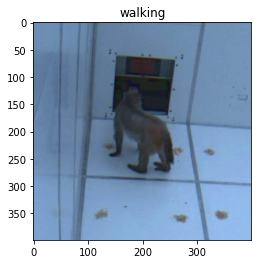

294 131 156 175


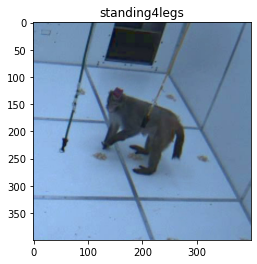

635 246 196 184


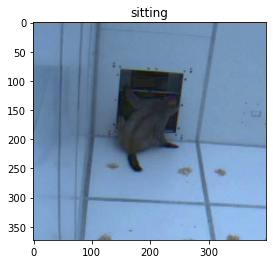

300 79 149 189


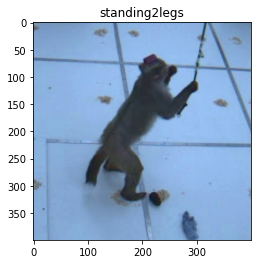

391 288 240 296


In [52]:
for l in labels:
    for index, row in samples[l].iterrows():
        x1, y1, w, h = row
        # print(index, row)
        cap.set(cv2.CAP_PROP_POS_FRAMES, index)
        ret, frame = cap.read()
        # print(frame.shape)
        (fh, fw, c) = frame.shape
        
        # if w <= CUT_SIZE and h <= CUT_SIZE:
        # corners = [[x1 - (SIZE-w)//2, y1 - (SIZE-h)//2],
        #             [x1 + w + (SIZE-w)//2, y1 - (SIZE-h)//2],
        #             [x1 + w + (SIZE-w)//2, y1 + h + (SIZE-h)//2],
        #             [x1 - (SIZE-w)//2, y1 + h + (SIZE-h)//2]
        #         ]
        y = np.clip([y1 - (CUT_SIZE-h)//2, y1 + h + (CUT_SIZE-h)//2], 0, fh)
        x = np.clip([x1 - (CUT_SIZE-w)//2, x1 + w + (CUT_SIZE-w)//2], 0, fw)
        frame = frame[y[0]:y[1],x[0]:x[1],:]

        padded_frame = cv2.copyMakeBorder(frame, frame.shape[])
        # else:
        #     # this is a problem!!!!
        #     pass


        

        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        plt.imshow(frame)
        plt.title(l)
        plt.show()
        print(x1, y1, w, h)
        break
   